- downscale the temperatures in the era5 land data for the centroid of the era5land cells
- use DEM (alos globe) and era5 land geopotential
- calculate the mean DEM elevation

- calculate the elevation difference (delta elevation)
- calculate the delta temperature per cell
- 

In [1]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import os



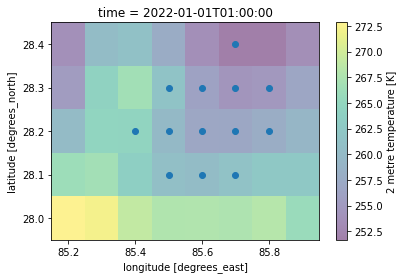

In [2]:
# test era5 land file
era5land = xr.open_dataset('/Users/varyabazilova/Desktop/paper2/Thesisfiles_Varya/climate/Era5/langtang/temp/2022.nc')
# csv with coordinates and geopotential (z) 
langtang_elevation = pd.read_csv('/Users/varyabazilova/Desktop/paper2/Thesisfiles_Varya/climate/elevation/geopotential_langtang.csv')

# plot together to see how points look
era5land.t2m.isel(time = 1).plot(alpha = 0.5)
plt.scatter(x = langtang_elevation.Longitude, y = langtang_elevation.Latitude)

In [3]:
# dem 30m
# langtang dem - alluvial fans dem part 9
dempath = '/Users/varyabazilova/Desktop/alluvial_fans/dem_all/new_points_catchmetns/all_points/1_dem/'

dem_hma = xr.open_dataset(dempath + 'dem_clip.tif')
# clip using the langtang-ish bbox

# lon = x 
min_lon = era5land.longitude.values.min() - 0.05
max_lon = era5land.longitude.values.max() + 0.05

# lat = y
min_lat = era5land.latitude.values.min() - 0.05
max_lat = era5land.latitude.values.max() + 0.05

dem = dem_hma.rio.clip_box(minx=min_lon, miny=min_lat, maxx=max_lon, maxy=max_lat)


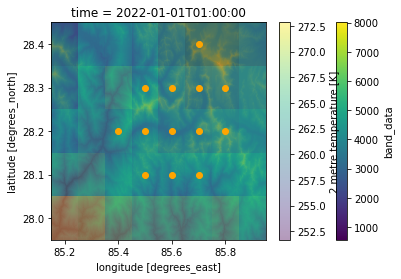

In [4]:
# plot dem together with points 


dem.band_data.plot()
era5land.t2m.isel(time = 1).plot(alpha = 0.4)
plt.scatter(x = langtang_elevation.Longitude, y = langtang_elevation.Latitude, color = 'orange')


## calculate the mean dem value per era5land pixel - xr.coarsen()

In [5]:
# resample the dem file to a lower resolution 
# for xarray coarsen you need a length of coordinates/grid for a new file
# dem

In [6]:
lat_len = len(era5land.latitude.values) # y
lon_len = len(era5land.longitude.values) # x 

y_len = len(dem.y.values)
x_len = len(dem.x.values)

coarsened_dem = dem.coarsen(x=int(x_len/lon_len), y=int(y_len/lat_len), boundary='trim').median()

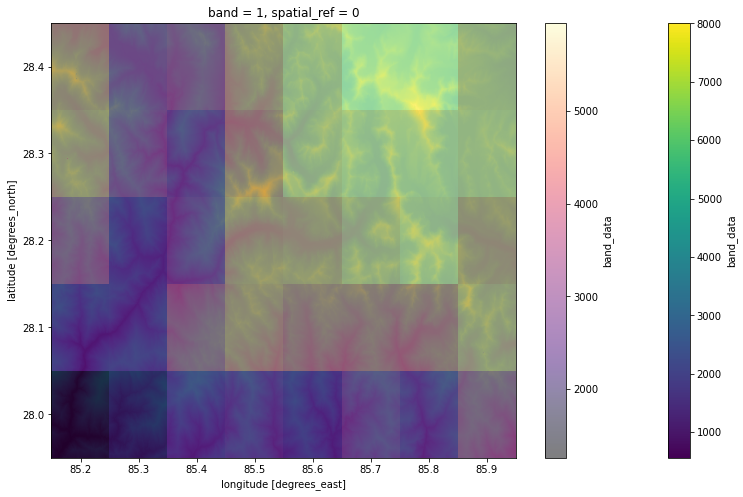

In [7]:
# plot all together to see of the grid matches

plt.figure(figsize = (13, 8))
dem.band_data.plot()
# era5land.t2m.isel(time = 1).plot()
coarsened_dem.band_data.plot(cmap = 'magma', alpha = 0.5)


## select values for the coordinates from the coarsen grid 

In [8]:
# langtang elevation - csv with z value for the geopotential 
longitudes = langtang_elevation.Longitude
latitudes = langtang_elevation.Latitude

selected = coarsened_dem.sel(x = longitudes, y = latitudes, method = 'nearest')

In [9]:
df = selected.to_dataframe()
df = df.reset_index()
df = df.drop_duplicates()
df = df.rename(columns = {'x':'Longitude', 'y':'Latitude'})

# round so that coordinates match
langtang_elevation = langtang_elevation.round(3)
df = df.round(3)

In [10]:
# df

### adjust temperature according to the elevation dofference

In [11]:
# merge together
merged = langtang_elevation.merge(df, on = ['Longitude', 'Latitude'])

# z - geopotential 
# band_data = dem data 
# delts H = difference between geopotential and DEM info
merged['delta_H'] = merged.z - merged.band_data 
merged['delta_t'] = merged.delta_H * 6.5/1000

In [12]:
merged

,cellnr,Latitude,Longitude,z,band,band_data,spatial_ref,delta_H,delta_t
0,12,28.1,85.5,4006.004,1,4576.0,0,-569.996,-3.704974
1,13,28.1,85.6,4116.322,1,4289.0,0,-172.678,-1.122407
2,14,28.1,85.7,4106.181,1,4268.0,0,-161.819,-1.051824
3,19,28.2,85.4,3513.108,1,3153.0,0,360.108,2.340702
4,20,28.2,85.5,4432.013,1,4688.0,0,-255.987,-1.663916
5,21,28.2,85.6,5007.776,1,4762.0,0,245.776,1.597544
6,22,28.2,85.7,5149.130,1,5152.0,0,-2.870,-0.018655
7,23,28.2,85.8,5078.555,1,5384.0,0,-305.445,-1.985392
8,28,28.3,85.5,4167.127,1,4451.0,0,-283.873,-1.845174
9,29,28.3,85.6,5154.559,1,5280.0,0,-125.441,-0.815366


In [13]:
# final table with cell number and delta temperature 

df = merged[['cellnr', 'delta_t']]
df

,cellnr,delta_t
0,12,-3.704974
1,13,-1.122407
2,14,-1.051824
3,19,2.340702
4,20,-1.663916
5,21,1.597544
6,22,-0.018655
7,23,-1.985392
8,28,-1.845174
9,29,-0.815366


### downscale the temperatures for each file as input

In [14]:

# Specify the path to the folder containing climate files
climate_folder = '/Users/varyabazilova/Desktop/paper2/downscaling_simple/langtang_climate'

# Step 1: Read the table data into a DataFrame
table_df = df
# Step 2: Iterate over each row in the DataFrame
for index, row in table_df.iterrows():
    cellnr = int(row['cellnr'])
    delta_t = row['delta_t']


    
    # Step 3: Read and update the corresponding file
    file_path = os.path.join(climate_folder, f'climatecell.{cellnr}.met')
    if os.path.exists(file_path):
        # Read the file into a DataFrame
        file_df = pd.read_csv(file_path)
        
        # Update Ta values
        file_df['Ta'] = file_df['Ta'] + delta_t
        
        # Save the updated DataFrame back to the file
        file_df.to_csv(file_path, index=False)
        print(f'Ta values updated for {file_path}')
    else:
        print(f'File {file_path} not found.')

print('All updates complete.')


Ta values updated for /Users/varyabazilova/Desktop/paper2/downscaling_simple/langtang_climate/climatecell.12.met
Ta values updated for /Users/varyabazilova/Desktop/paper2/downscaling_simple/langtang_climate/climatecell.13.met
Ta values updated for /Users/varyabazilova/Desktop/paper2/downscaling_simple/langtang_climate/climatecell.14.met
Ta values updated for /Users/varyabazilova/Desktop/paper2/downscaling_simple/langtang_climate/climatecell.19.met
Ta values updated for /Users/varyabazilova/Desktop/paper2/downscaling_simple/langtang_climate/climatecell.20.met
Ta values updated for /Users/varyabazilova/Desktop/paper2/downscaling_simple/langtang_climate/climatecell.21.met
Ta values updated for /Users/varyabazilova/Desktop/paper2/downscaling_simple/langtang_climate/climatecell.22.met
Ta values updated for /Users/varyabazilova/Desktop/paper2/downscaling_simple/langtang_climate/climatecell.23.met
Ta values updated for /Users/varyabazilova/Desktop/paper2/downscaling_simple/langtang_climate/cl